In [2]:
from __future__ import unicode_literals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import json
import gzip
import spacy
#import textacy
%matplotlib inline
np.random.seed(32113)
import pickle
from sklearn.decomposition import NMF
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.decomposition import NMF
from nltk.corpus import stopwords
from spacy.en import English
from sklearn.grid_search import GridSearchCV
#import xgboost as XGB
import string
parser = English()
import data_prep_for_test_run as dp
import math

---------------------------

## Loading data

In [3]:
# loading reviews and meta data
path = './reviews_Video_Games.json.gz'
meta_path = './meta_Video_Games.json.gz'

### Before creating  a model:
In order to create an accurate model, we want to filter reviews.  
we filter review by looking at categories of product in meta data. 
  
Below are codes to check products associated with review data.
It displays types of categories and number of 'Home & Kitchen' products that are associated with each category.  
As you can see, there are many 'Home & kitchen' products  
that are associated with categories that are unrelated to Home & Kitchen. 
By looking at this list, we can decide how to filter products.  
  
In this case, I would filter out categories where total number is less than 2000.  
If you want to strictly work on Home & kitchen products, I will filter out categories less than 10000.  

Once we merge review data and meta data, we will filter out reviews by these categories.

In [ ]:
#run this code if you do not know if products belong to unrelated categories
df_test = dp.Data_prep1(path)
meta = dp.getDF(meta_path)
meta = dp.add_meta_info(df_test,meta,'Video Games',50,True)

------------

## Preparing train and test data

### Merging data, Cleaning Meta data  
the function **df_prep1** will do three things for you:  
1. Cleaning meta data for you (gets rid of Nan values)  
2. Add features created from Meta data (categories, sales ranking within the categories and price)   
3. Filter out categories that are not associated with the data topics  
4. Merge meta data with review datas and output pandas dataframe 
5. reassign values of 'helpful' features into 2 values and calculate percentage of positive votes on a review.  
  
inputs:  
**dp.df_prep1( a , b , c , d )**  
a = path of your review data (json.gz format)  
b = path of your meta data (json.gz format)  
c = topic keys: category names that every product in your dataset is associated with.  
for example: 'Video Games', 'Home &amp; Kitchen' etc.  
d = filtering out categoiry if the total number of product associated with that category is less than this number.  

In [4]:
df= dp.df_prep1(path, meta_path,'Video Games',50)
# should spit out average price for each category.  
# these price will be filling Nan under price feature

average price for Electronics is $33.51
average price for Video Games is $61.456088411


data_prep_for_test_run.py:891: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_topic['price'] = df_topic['price'].fillna(average_val)


average price for Software is $23.8273076923
--- 312.00524807 seconds ---


In [ ]:
df.columns

In [ ]:
df

### Split train and test dataset:
In NLP prediction model, it is safe to run train and test dataset before running model building functions.  
Here, we are randomly selecting 85% of data as a train dataset.  
and assign rest of the data as test dataset.  

In [5]:
ind = df.index
random_ind = np.random.choice(list(ind), int(len(df)*.85), replace=False)
df_train = df.loc[list(random_ind)]
test_ind = [i for i in ind if i not in random_ind]
df_test = df.loc[test_ind]

In [7]:
## if you want to save test and training dataframe...
#df_test.to_pickle("./HomeandKitchen_df_test_15percent.pkl")
#df_train.to_pickle("./HomeandKitchen_df_train_85percent.pkl")

### tfidf model
**df_prep_train1** function creates tfidf matrix and tfidf sklearn model.  
It also saves tfidf matrix and tfidf skearn model as a pickle file in case something happens later.  
  
inputs:
**df_prep_train1( a , b , c(optional) )**  
a = your training dataframe created above  
b = filename/keyword. this string will be used to name tfidf matrix and tfidf sklearn model pickle file.  
c = a list containing parameters of TfidfVectorizer sklearn class. this is optional.  
default values for this input is:  tfidf_set = [2,0.95,10000,'l2']  
  
where TfidfVectorizer(stop_words=STOPLIST, tokenizer=lemma, min_df=tfidf_set[0], max_df=tfidf_set[1], max_features =tfidf_set[2], norm=tfidf_set[3])  
  
visit Sklearn web for more details.     
http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [6]:
tfidf_matrix, tfidf_model  = dp.df_prep_train1(df_train,'Video Games')

--- 121.213349819 seconds ---


### before running NMF, check your elbow!
the function **NMF_elbow** will give you stats about reconstruction error for different K component.  
you want to chose right K where slope changes significantly.  
Since the data we are using does not have obvious elbow,  
I added error difference between K and error of each K.  

inputs:  
**NMF_elbow( a , b )**  
a = your tfidf matrix  
b = range of K (list)  

calculated in 11.8010890484 seconds 


error difference
0.275268431994
0.187867672658
0.154415273565
0.133671663843
0.138395448223
0.112929126418
0.120690769262
0.105908771244
0.0912280233686
0.102247955315


error k = 1: 58.1219805649
error k = 2: 57.8467121329
error k = 3: 57.6588444602
error k = 4: 57.5044291867
error k = 5: 57.3707575228
error k = 6: 57.2323620746
error k = 7: 57.1194329482
error k = 8: 56.9987421789
error k = 9: 56.8928334077
error k = 10: 56.8016053843
error k = 11: 56.699357429


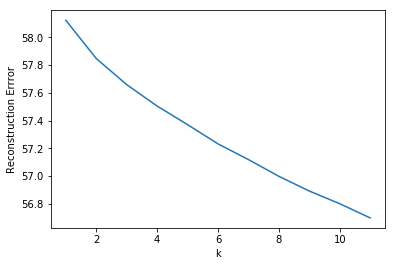

In [6]:
dp.NMF_elbow(tfidf_matrix, range(1,12))

### Adding NMF results and tfidf results onto training dataset
**df_prep_train2** function does lots of things here.
1. calculate NMF from the tfidf matrix that you created from df_prep_train1
2. add NMF results as features (predict percentage values for each NMF topics)
3. print outs top 20 words that are highly associated with each NMF topics.
4. add tfidf results to training dataset  
(you can select how many words you want to add to the data frame by choosing values for max_feat (e))  
5. saves resulting training dataframe, NMF model and tfidf feature model as pickle files

inputs:  
**df_prep_train2**( a , b , c , d , e (opt) , f (opt), g (opt))  
a = training dataframe.  
b = filename/keyword. this string will be used to name NMF model and tfidf feature model pickle file.  
c = tfidf matrix.
d = tfidf model.  
e = max feature (optional). default value = 1000. 
will create tfidf model with top 1000 (default) words   
and create features of these top 1000 words in your training dataframe.  
f = NMF parameters (optional). default values NMF_set = [6,'cd',0.1,0.5].  
where NMF(n_components=NMF_set[0], solver=NMF_set[1], random_state=32113, alpha=NMF_set[2], l1_ratio=NMF_set[3])  
visit Sklearn web for more details.  
http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html  

g = tfidf parameters (optional). default values = [2,0.95,10000,'l2'].  
  
where TfidfVectorizer(stop_words=STOPLIST, tokenizer=lemma, min_df=tfidf_set[0], max_df=tfidf_set[1], max_features =tfidf_set[2], norm=tfidf_set[3])  
visit Sklearn web for more details.  
http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html  
(3rd value will be replaced by max feature (e))  

In [7]:
df_train_new,NMF_model,TFIDF_feat_model = dp.df_prep_train2(df_train, 'Video Games', tfidf_matrix, tfidf_model,1000, [10,'cd',0.1,0.5])

Topic #0:
game play like good make time character really player new fun thing look story feel say level great think want
Topic #1:
xbox ps3 360 gb drive console microsoft sony buy hard cable kinect disc ray blu download playstation ps2 slim usb
Topic #2:
wii u nintendo remote sport game motion nunchuck buy control zelda use u. gamecube fit tv console kid board bundle
Topic #3:
drm game ea steam install buy server play purchase pay internet computer software securom customer amazon pc download product money
Topic #4:
exercise workout fitness board balance weight fit yoga routine trainer cardio kinect wii program gym use training active calorie body
Topic #5:
mario super nintendo ds kart luigi bro game galaxy 3d 3ds 64 new bowser brother bundle classic princess peach mini
Topic #6:
sim sims expansion new pack city ea house 3 2 career family object maxis pet create like build thing trait
Topic #7:
controller charge button battery use usb plug wireless work driver rumble pad dualshock anal

In [2]:
## in case you need to load each model, you can load models here

## df_prep1/train-test split result
#df_train = pd.read_pickle('./HomeandKitchen_df_train_85percent.pkl')
#df_test = pd.read_pickle('./HomeandKitchen_df_test_15percent.pkl')

## df_prep_train1 results
# with open(r"HomeAndKitchen_tfidf_matrix.pickle", "rb") as input_file:
#     tfidf_matrix = pickle.load(input_file)
# with open(r"HomeAndKitchen_tfidf_model.pickle", "rb") as input_file:
#     tfidf_model= pickle.load(input_file)

## df_prep_train2 results
df_train_new = pd.read_pickle('./preped_HomeAndKitchen_max_feature1000.pkl')
# with open('HomeAndKitchen_NMF_model.pickle', "rb") as input_file:
#     NMF_model = pickle.load(input_file)
# with open(r"HomeAndKitchen_tfidf_feat_model.pickle", "rb") as input_file:
#     TFIDF_feat_model= pickle.load(input_file)
df_test_new = pd.read_pickle('./preped_HomeAndKitchen_df_test.pkl')

### Preparing test dataset

Now we want to prepare test dataset.  
I simply used MNF and tfidf models of training dataset to transform test dataset.  


**df_prep_test** function adds features for test data.  
It uses transform method of NMF and tfidf models that we just trained with training dataset.  
The function outputs test dataframe which contains same amount of features as training dataframe.  
It also saves output dataframe as a pickle file.  

inputs:  
**df_prep_test**( a , b , c , d , e )  
a = test dataframe we created previously. (read Split train and test dataset section above)  
b = tfidf model trained with training dataframe.  
c = NMF model that was trained with training dataframe.
d = second tfidf model that is used to create tfidf term features.  
e = filename/keywords used as a name of pickle file.  

In [8]:
df_test_new = dp.df_prep_test(df_test, tfidf_model,NMF_model, TFIDF_feat_model, 'Video Games')

          reviewerID        asin  \
32     APGAQX4VA5SAX  B0000296YH   
1637   A74TA8X5YQ7NE  B001B5U80K   
1811  A1SB9BNNGKNX2Z  B001O3066U   
3735  A3NPSVM5H907RF  B009S4JZKK   
1     A15C05TWM2J5PL  B00000DMB3   
2      ACQDEUA5ECO7J  B00000DMB3   
11    A3R6DWGDCLH7IY  B00000JRSB   
13    A1046G79VW4NKN  B00000JRSB   
14    A3OBL19DP3UR9H  B00000JRSB   
19    A1AP90K9PG0YQ7  B00000K4KT   
24    A2BO5HRT9HFWAG  B00001IVRD   
37    A31BO23GECXU13  B00002NDRL   
42    A2UTTRGMOVMR6U  B00002S6CC   
45    A21X68W8SJA3T4  B00002S6CC   
50    A2B5XH474FI20T  B00002SU5D   
72    A35RDX6W4CINQ9  B00004T1M7   
89    A3N1V8LIFT0RU6  B00004VP4M   
91     AJSVA9Y3UVXAJ  B00004WKHO   
96    A26BY28XSBPBNU  B00004YRPD   
111    AQ40L2YGV7C42  B000059S8D   
124   A2RRVDJN4VVQ5J  B00005LABK   
126   A2W3H2FFKN330R  B00005LBHM   
131   A2ES7IT00AP3F1  B00005MDZY   
135    AQ40L2YGV7C42  B00005N6ZL   
166   A3OU7B1W9Y3JBH  B00005R5PO   
173    ABUWRGAW6CWP7  B00005TNI6   
179   A3CFSQ5QMBU32V  B00005

--- 47.3345038891 seconds ---


-----------------

### Taking out columns that are all 0

Before running ensemble method algorithm,  
I want to identify any columns that only have value 0 in my training set.  
These columns will not affect my prediction results and should be removed to reduce dimensionality of my model.  
  
In order to do this, I identify these columns from my training dataset first and  
removed them from both training and test dataset.  
Test dataset may contain columns with zero values that are different from training set.  
However, these will be kept in our dataset because we only care about columns with zeros  
in our training set during our model building process.

In [9]:
zero_columns_train = df_train_new.columns[(df_train_new == 0).all()]
print zero_columns_train

Index([u'Drums', u'Skins', u'Fire TV'], dtype='object')


In [10]:
df_train_new = df_train_new.drop(zero_columns_train, 1)
df_test_new = df_test_new.drop(zero_columns_train,1)

## making XGboost model

### preparing labels for prediction modeling
Before running prediction model with XGboost, we want to create labels for our model. 
For this prediction model, I created a feature called 'helpful_percent'  
which indicates percentage of user voted review as helpful review.
I want to split this feature into two groups to make my prediction model binary classifier.

the function **label_prep** is a function that prepares label feature.
It also prints out total number of reviews that belongs LOW and HIGH label class in your data frame.  

input:
**dp.label_prep( a , b )**
a = train or test dataframe.  
b = float value that splits label.  
the label feature has value HIGH or LOW.  
If the 'helpful_precent' is higher than the value of b, label == HIGH.  
If the 'helpful_precent' is lower than the value of b, label == LOW.  
I usually set this values around 0.75 to 0.9.  
What I care most here is predicting HIGH correctly.

In [11]:
#df = pd.read_pickle("./preped_videogame_1000_df.pkl")
print "training data:  "
df_train_new = dp.label_prep(df_train_new, 0.75)

training data:  
highly helpful count: 2232
not helpful count: 1366


In [12]:
print "test data: "
df_test_new = dp.label_prep(df_test_new,0.75)

test data: 
highly helpful count: 394
not helpful count: 242


### adjusting number of data in training and test sets
Another step you want to apply before applying XGboost.
Since training and test dataframe most likely have unbalanced label classes (HIGH and LOW),  
we want to balance label classes by randomly select set numbers of reviews from each class.  
From the print statement of previous step (label_prep), you know how many reviews exist in both HIGH and LOW label class.  
Select a number so that the number of reviews for HIGH and LOW are about same.  
  
For example:  
if label_prep prints out:
  
highly helpful count: 34290  
not helpful count: 25345  

I would select number 25000 (if you really want to increase number of reviews, 27500?).  
  
input:  
**df_for_XGBOOST**( a , b )  
a = dataframe  
b = maximum number of reviews in each label class.  

In [13]:
train_X, train_y, df_new_train = dp.df_for_XGBOOST(df_train_new,1400)
test_X, test_y, df_new_test = dp.df_for_XGBOOST(df_test_new,2000)

### XGboost model
function **XGBOOSTING** creates XGboost model, fits training dataset and prints out test data accuracy score.

inputs:
**XGBOOSTING(train_X,test_X,train_y,test_y,xgb_para=[4000,0.15])**
a = X train  
b = X test  
c = label train  
d = label test  
e = parameters for XGboost. xgb_para = [4000,0.15]  
where xgb = XGB.XGBClassifier(n_estimators=xgb_para[0], learning_rate=xgb_para[1])  
  
  
### Random Forest model
function **r_forest** runs random frest insted of XGBoost. Only difference is the parameter.  
  
inputs:  
**r_forest(train_X,test_X,train_y,test_y,parameter=[1000,'auto',none])**  
parameter = [1000,'auto',None]  
where rf = RandomForestClassifier(n_estimators=parameter[0], max_features = parameter[1], max_depth=parameter[2])  

In [14]:
#model = dp.XGBOOSTING(train_X,test_X,train_y,test_y,xgb_para=[4000,0.15])
model = dp.r_forest(train_X,test_X,train_y,test_y, [1000,50,None])

--- 21.9913899899 seconds ---
RF score: 86.32%


### XGboost stats (Important Features and confusion matrix)
following function prints out Top15 important features of the prediction model,  
confusion matrix that is in the markdown format table,  
LOW prediction rate and HIGH prediction rate.  

input:  
**xgb_stats**( a , b , c , d )  
a = XGboost model  
b = dataframe (an output of df_for_XGBOOST function)  
c = test X data  
d = test label data  

In [15]:
dp.xgb_stats(model,df_new_test,test_X,test_y)

 **TOP15 Important Features**  
leave : 0.672773805517%  
new : 0.699647532105%  
Accessories : 0.818463379415%  
percent_GROUP_1 : 0.84741773711%  
feature : 0.853787932902%  
enjoy : 0.907305699071%  
percent_GROUP_4 : 0.960251319721%  
sort : 1.10448132333%  
die : 1.12857298946%  
surprise : 1.22353217363%  
price : 1.42303649998%  
gamecube : 1.61354571494%  
rank_values : 3.45245920816%  
text_length : 6.00004820027%  
overall : 8.50613117299%  


 |                 |       NOT HELPFUL TRUE       |        HIGHLY HELPFUL TRUE        |
     |:--------------: | :-------------------:|:-----------------------:|
     |       NOT HELPFUL PRED     |        205.0        |           50.0        |
     |        HIGHLY HELPFUL PRED     |        37.0        |           344.0        |

LOW prediction rate: 84.71%
HIGH prediction rate: 87.31%



----------


## Results

### XGB RESULTS with 75% threshold
  
n_estimators=2000,learning_rate=0.1,subsample =0.9, max_depth =25, gamma = 0.3, colsample_bytree =0.8, reg_alpha = 0.01  
Computation: 2025.37363505 seconds  
score: 77.24%  
 **TOP15 Important Features**  
percent_GROUP_5 : 1.06626739725%  
overall : 1.06887128204%  
plan : 1.08449421823%  
tank : 1.10662672669%  
canister : 1.14698605612%  
unit : 1.20166642591%  
bring : 1.30321569741%  
percent_GROUP_3 : 1.35008459911%  
firm : 1.64041146636%  
percent_GROUP_8 : 1.82528309524%  
percent_GROUP_1 : 2.2015362978%  
text_length : 3.62322628498%  
percent_GROUP_10 : 3.6336414516%  
price : 3.9552140981%  
rank_values : 4.77411784232%  


 |                 |       NOT HELPFUL TRUE       |        HIGHLY HELPFUL TRUE        |  
     |:--------------: | :-------------------:|:-----------------------:|  
     |       NOT HELPFUL PRED     |        1426.0        |           473.0        |  
     |        HIGHLY HELPFUL PRED     |        397.0        |           1527.0        |  
  
LOW prediction rate: 78.22%  
HIGH prediction rate: 76.35%  

### Best Random Forest result with 75% threshold
  
1000,50,None  
224 sec.  
Overall accuracy: 76.82%  
**TOP15 Important Features**  
bring : 0.583035827847%  
tank : 0.595895823154%  
canister : 0.630979208038%  
whatev : 0.656540650705%  
percent_GROUP_3 : 0.672279437706%  
percent_GROUP_8 : 0.802946732109%  
percent_GROUP_10 : 0.885243888022%  
percent_GROUP_1 : 0.888022789254%  
firm : 0.905402625438%  
rank_values : 1.02694375671%  
loud : 1.09024337464%  
price : 1.33508923173%  
main : 1.36355712797%  
text_length : 2.80382163106%  
overall : 8.20653149646%  


 |                 |       NOT HELPFUL TRUE       |        HIGHLY HELPFUL TRUE        |  
     |:--------------: | :-------------------:|:-----------------------:|  
     |       NOT HELPFUL PRED     |        1492.0        |           555.0        |  
     |        HIGHLY HELPFUL PRED     |        331.0        |           1445.0        |  

LOW prediction rate: 81.84%  
HIGH prediction rate: 72.25%  

#### gridsearchcv:

In [7]:
param_test1 = {
 'min_child_weight':range(1,6,2)}

In [11]:
start_time = time.time()
gsearch = GridSearchCV(estimator = XGB.XGBClassifier( learning_rate =0.1, n_estimators=2000, max_depth=25,
 min_child_weight=1, subsample=0.9), param_grid = param_test1, cv=5)
gsearch.fit(train_X,train_y)
gsearch.best_score_, gsearch.best_params_, gsearch.best_estimator_
print("Computation: %s seconds  " % (time.time() - start_time))

Computation: 24289.086812 seconds  


In [12]:
gsearch.best_score_

0.7902

In [13]:
gsearch.best_params_, gsearch.best_estimator_

({u'min_child_weight': 1},
 XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
        gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=25,
        min_child_weight=1, missing=None, n_estimators=2000, nthread=-1,
        objective='binary:logistic', reg_alpha=0, reg_lambda=1,
        scale_pos_weight=1, seed=0, silent=True, subsample=0.9))